# Real-Time Corona Mask Detection

In [28]:
import os
from os import listdir
from os.path import isfile, join
import zipfile
import cv2 # OpenCV
import matplotlib.pyplot as plt
import xmltodict # PyPI library that treats XMLs as JSON files (containing key values pairs)
import torch # PyTorch
import torchvision # PyTorch library containing useful attributes and functionalities
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [29]:
#!pip install torch==1.5.1+cpu torchvision==0.6.1+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [30]:
os.chdir('/')
os.chdir('D:/iit project code/Datasets')
os.getcwd()

'D:\\iit project code\\Datasets'

In [31]:
# Link for dataset : https://www.kaggle.com/andrewmvd/face-mask-detection
# Extracting the data from archive
#zip_file = "667889_1176415_bundle_archive.zip"
#zip_files = zipfile.ZipFile(zip_file)
#zip_files.extractall()

In [32]:
def getImageNames():
    '''
    function to get the names of images in the dataset
    '''
    image_names = []
    for dirname, _, filenames in os.walk('D:/iit project code/Datasets/combined_data/images'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension != '.xml':
                image_names.append(filename)
    return image_names

In [33]:
def get_path(image_name):
    '''
    function to get the path of the images and their labels in the dataset
    '''
    #home_path = '/IIT-K Project/'
    home_path = 'D:/iit project code/Datasets/combined_data/'
    image_path = home_path + 'images/' + image_name
    if image_name[-4:] == 'jpeg':
        label_name = image_name[:-5] + '.xml'
    else:
        label_name = image_name[:-4] + '.xml'
    label_path = home_path + 'annotations/' + label_name
    return  image_path, label_path

In [34]:
def parse_xml(label_path):
    '''
    function to convert the labels of XML files to dictionary format and return the classes of dataset along with bounding boxes
    '''
    x = xmltodict.parse(open(label_path, 'rb'))
    item_list = x['annotation']['object']
    # when image has only one bounding box
    if not isinstance(item_list, list):
        item_list = [item_list]
    result = []
    for item in item_list:
        name = item['name']
        bndbox = [(int(item['bndbox']['xmin']), int(item['bndbox']['ymin'])),
                  (int(item['bndbox']['xmax']), int(item['bndbox']['ymax']))]       
        result.append((name, bndbox))
    size = [int(x['annotation']['size']['width']), 
            int(x['annotation']['size']['height'])]
    return result, size  # result contains classes & its bounding box's x,y coords; size contains width & height of bounding box

In [35]:
def visualize_image(image_name, bndbox=True):
    '''
    function to visualize the images in the dataset along with appropriate bounding boxes according to their classes
    '''
    image_path, label_path = get_path(image_name)
    image = cv2.imread(image_path)  # reading the image using OpenCV's imread function
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converting image to RGB format as OpenCV reads image in BGR format
    if bndbox:  # bndbox is set as true in function parameter
        labels, size = parse_xml(label_path)
        thickness = int(sum(size)/400)
        for label in labels:
            name, bndbox = label # label has the classes and bound box's x,y coordd of result as defined by the above fucntion
            if name == 'without_mask' or name == 'bad' : # if the label is without_mask, a bounding box of red color is drawn
                cv2.rectangle(image, bndbox[0], bndbox[1], (255, 0, 0), thickness)
            elif name == 'with_mask' or name == 'good':  # if the label is with_mask, a bounding box of green color is drawn
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 255, 0), thickness)
            elif name == 'mask_weared_incorrect' or name== 'none': # if the label is mask_weared_incorrect, a bounding box of blue color is drawn
                cv2.rectangle(image, bndbox[0], bndbox[1], (0, 0, 255), thickness)
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [36]:
image_names = getImageNames() # getting the image names

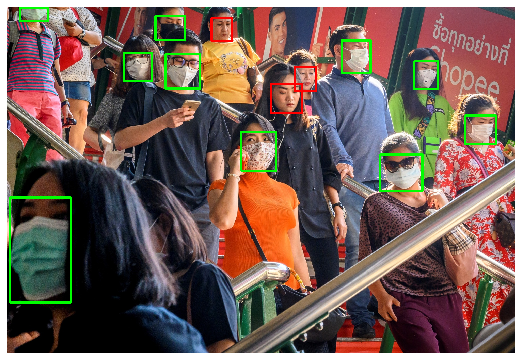

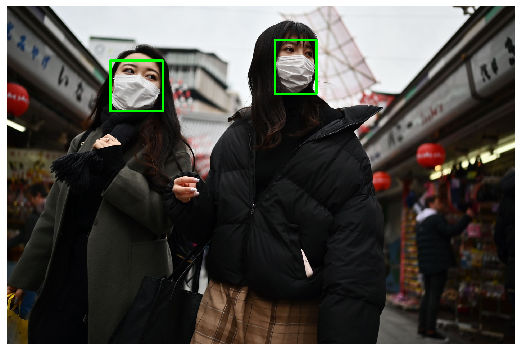

In [37]:
# Testing the bounding boxes on a few images
for i in range(2):
    visualize_image(image_names[i])

In [38]:
def cropImage(image_name):
    '''
    function to crop the part of image inside bounding box, and that cropped part will be
    fed as input in a pre-trained neural network ResNet-50, to detect the presence of the mask
    '''
    image_path, label_path = get_path(image_name)
    # image pre-processing
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # getting the labels and bounding boxes' coords and size
    labels, size = parse_xml(label_path)
    cropedImgLabels = []
    for label in labels:
        # from labels we extract the label names and annotation parameters
        name, bndbox = label
        # cropping out the part of image inside bounding box
        croped_image = image[bndbox[0][1]:bndbox[1][1], bndbox[0][0]:bndbox[1][0]]
        label_num = 0
        # as label contains categorical variables, they are assigned numeric categories
        if name == 'with_mask' or name == 'good':
            label_num = 0
        elif name == 'without_mask' or name == 'bad' :
            label_num = 1
        elif name == 'mask_weared_incorrect' or name== 'none':
            label_num = 2
        # getting the cropped image and label
        cropedImgLabel = [croped_image, label_num]
        # creating the list of all cropped images exracted from the input image
        cropedImgLabels.append(cropedImgLabel)
    return cropedImgLabels

In [40]:
# Creating train directory with separate folders belonging to separate classes and also the models directory to save the models

dir_name = 'train/'
label_0_dir = dir_name + "0/"
label_1_dir = dir_name + "1/"
label_2_dir = dir_name + "2/"
models_dir = "models/"

os.mkdir(dir_name)
os.mkdir(label_0_dir)
os.mkdir(label_1_dir)
os.mkdir(label_2_dir)
os.mkdir(models_dir)

In [41]:
label_0_counter = 0
label_1_counter = 0
label_2_counter = 0
for image_name in image_names:
    cropedImgLabels = cropImage(image_name)
    # iterating through the cropped images and their target labels list
    for cropedImgLabel in cropedImgLabels:
        # extracting the images and labels from the list
        label = cropedImgLabel[1]
        img = cropedImgLabel[0]
        # renaming the images with their index numbers along with appending their directory names
        if label == 0:
            croped_img_name = str(label_0_counter) + ".jpg"
            cv2.imwrite(label_0_dir + croped_img_name, img)
            label_0_counter += 1
        elif label == 1:
            croped_img_name = str(label_1_counter) + ".jpg"
            cv2.imwrite(label_1_dir + croped_img_name, img)
            label_1_counter += 1
        elif label == 2:
            croped_img_name = str(label_2_counter) + ".jpg"
            cv2.imwrite(label_2_dir + croped_img_name, img)
            label_2_counter += 1

In [42]:
# Making list of images according to their respective classes
filenames_label_0 = [f for f in listdir(label_0_dir) if isfile(join(label_0_dir, f))]  
filenames_label_1 = [f for f in listdir(label_1_dir) if isfile(join(label_1_dir, f))]
filenames_label_2 = [f for f in listdir(label_2_dir) if isfile(join(label_2_dir, f))]
print("Total number of images: " + str(len(filenames_label_0) + len(filenames_label_1) + len(filenames_label_2)))
print("Number of images labeled 0: " + str(len(filenames_label_0)))
print("Number of images labeled 1: " + str(len(filenames_label_1)))
print("Number of images labeled 2: " + str(len(filenames_label_2)))

Total number of images: 7986
Number of images labeled 0: 6353
Number of images labeled 1: 1384
Number of images labeled 2: 249


In [43]:
# Using GPU for training if available else using CPU to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [44]:
# Loading the pre-trained ResNet-50 model for image classification on cropped images
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\ACER/.cache\torch\checkpoints\resnet50-19c8e357.pth


In [45]:
for layer, param in model.named_parameters():
    print(layer)
    if 'layer4' not in layer:
        # setting requires grad = False, as we do not want to backpropagate and change the weights and gradients,
        # we will freeze this layer for feature extraction and connect it to our fully connected trainable layers
        param.requires_grad = False 
# Adding our fully connected layer to the pre-trained ResNet-50 block
model.fc = torch.nn.Sequential(torch.nn.Linear(2048, 512),
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.2),
                                 torch.nn.Linear(512, 3),
                                 torch.nn.LogSoftmax(dim=1))
print(model)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [46]:
# Creating a pipeline for series of tranformations needed to apply to the data
train_transforms = transforms.Compose([
    # resizing the images to 224*224 size arrays
    transforms.Resize((224,224)),
    # converting to PyTorch compatible tensor from ndarray type
    transforms.ToTensor(),
    # normalizing and scaling the image between [0,1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [47]:
# Getting the data from the directory and applying the transformations defined above
dataset = datasets.ImageFolder(dir_name, transform = train_transforms)

# Dividing the dataset into train, validation and test data
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - val_size

# Randomly splitting the data for no imbalance of class, and the model performs robustly when trained on random shuffle
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print('Train set size: ', len(train_dataset))
print('Validation set size: ', len(val_dataset))
print('Test set size: ', len(test_dataset))

Train set size:  6388
Validation set size:  798
Test set size:  800


In [48]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Loading the train data
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
# Loading the validation data
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
# Loading the test data
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

# Using cross-entropy loss and adam optimizer (an upgrade to stochastic gradient descent with momentum capabilities)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [52]:
#model.cuda()

In [55]:
total_epoch = 20
training_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
# Training the model
for epoch in range(total_epoch):
    total_train = 0
    correct_train = 0
    epoch_train_loss = 0
    for X, y in train_loader:
        #X, y = X.cuda(), y.cuda()
        # setting zero_grad, as in PyTorch, optimizer keeps accumulating gradients during each backpropagation
        optimizer.zero_grad()
        # forward pass
        result = model(X)
        # calculating the loss
        loss = criterion(result, y)
        # adding the training loss for better tracking of loss minimization process
        epoch_train_loss += loss.item()
        ##################################accuracy##################
        _,maximum_train = torch.max(result.data,1)
        total_train+=y.size(0)
        # summing all the correct predictions by matching with the true lables for calculating accuracy
        correct_train += (maximum_train == y).sum().item()  
        acc = correct_train/total_train
        # executing backward propagation for calcuation of gradients
        loss.backward()
        # updating the weights using the calculated gradients 
        optimizer.step()
    train_accuracy.append(acc)
    training_losses.append(epoch_train_loss)
    epoch_val_loss = 0
    correct = 0
    total = 0
    # torch.no_grad() ->  it impacts the autograd (backpropagation) engine and deactivates it. It will reduce the
    #                     memory usage and speed up the computations and hence we won't be able to perform backprop
    with torch.no_grad():
        for X, y in val_loader:
          #  X, y = X.cuda(), y.cuda()
            # forward pass
            result = model(X)
            # calculating the loss
            loss = criterion(result, y)
            # adding the validation loss for better tracking of loss minimization process
            epoch_val_loss += loss.item()
            # extracting the indices of maximum values from each row of predictions
            # like, if second prediction is hightest, it will return 1 , the index of second prediction
            # then we will compare with y which has the correct label for that image with predicted label
            _, maximum = torch.max(result.data, 1)
            total += y.size(0)
            # summing all the correct predictions by matching with the true lables for calculating accuracy
            correct += (maximum == y).sum().item()      
    val_losses.append(epoch_val_loss)
    # calculating the valildation accuracy
    accuracy = correct/total
    val_accuracy.append(accuracy)
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", Accuracy: ", accuracy)
    if val_losses[-1] == min(val_losses) or abs(val_losses[-1]-training_losses[-1]) < 0.5:
        # creating a dictionary with model parameters for saving
        checkpoint = {'model': model, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict()}
        # saving the model
        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

EPOCH: 0 , Training Loss: 23.456978138536215 , Validation Loss: 1.5698849856853485 , Accuracy:  0.9624060150375939
Model saved


KeyboardInterrupt: 

In [ ]:
# Visualizing training and validation loss changes throughout the training process
plt.plot(range(total_epoch), training_losses, label='Training Loss')
plt.plot(range(total_epoch), val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(total_epoch), train_accuracy, label='Training accuracy')
plt.plot(range(total_epoch), val_accuracy, label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
best_epoch = 2 # deciding based on lowest validation loss and highest accuracy comparitively to prevent underfitting/overfitting
def load_checkpoint(filepath):
    '''
    function to load the saved model
    '''
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    # as we have to perform testing, we don't need backpropagation so setting 'requires_grad' as false
    for parameter in model.parameters():
        parameter.requires_grad = False
    # model.eval() ->  .eval() does not change any behaviour of gradient calculations , but are used to set specific layers
    #                  like dropout and batchnorm to evaluation mode i.e. dropout layer won't drop activations and 
    #                  batchnorm will use running estimates instead of batch statistics.
    return model.eval()
filepath = models_dir + str(best_epoch) + ".pth"

In [36]:
loaded_model = load_checkpoint(filepath)
train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

In [37]:
# Testing accuracy of the model
correct = 0
total = 0    
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.cuda(), y.cuda()
        # forward pass
        result = loaded_model(X)
        # calculating accuracy
        _, maximum = torch.max(result.data, 1)
        total += y.size(0)
        correct += (maximum == y).sum().item()
accuracy = correct/total
print("Accuracy: " + str(round(accuracy*100,2)) + "%")

Accuracy: 96.08%
